In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt 
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

In [48]:
class Processing:
    def __init__(self, filedataset, begining_training, end_training,end_testing, timestamp, features, target):
        self.timestamp = timestamp
        self.features  = features
        self.begining_training = begining_training
        self.end_training = end_training
        self.end_testing = end_testing
        self.df  = self.importDataset()
        self.x_train = []
        self.y_train = []
        self.x_test  = []
        self.y_test  = []
        self.scaler_x = None
        self.scaler_y = None
        self.target = target
        self.df_training =  None
        self.df_test = None
        self.splitData()
    
    
    def diffdataset(self, dataset):
        #self.value_primary = self.df[self.features].values[0]
        #self.value_primary = self.value_primary.reshape(1,4)
        #self.df[self.features] = np.log( self.df[self.features]).diff().dropna()
        #dool =  np.cumprod( np.r_[ value_primary , np.exp( self.df[self.features].dropna().values ) ], axis=0 )
        dataset = np.log( dataset).diff().dropna()
        print(dataset)
        return dataset 

    def importDataset(self):
        parser = lambda x: pd.datetime.strptime(x, "%Y.%m.%d %H:%M:%S")
        df = pd.read_csv( filedataset, sep=';', header=0, parse_dates=['time'],date_parser=parser) 
        return df
    
    def selectInterval(self, start, end):
        mask = (self.df['time'] > start) & (self.df['time'] <= end )
        return self.df.loc[mask]
    
    def scalerDataset(self, dataset):
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.scaler_x.fit(dataset)
        self.scaler_y.fit(self.df[[target]])
        return self.scaler_x.transform(dataset)

    def processXY(self, dataframe):
        length = len(dataframe)
        x_data = []
        y_data = []
        for i in range(self.timestamp, length):
            x_data.append( dataframe.iloc[i-self.timestamp:i,:].values)
            y_data.append( dataframe.iloc[i,self.features.index(target)])
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        x_data = np.reshape(x_data, (x_data.shape[0], self.timestamp, len(features)))
        return x_data, y_data
     
    def splitData(self):
        #Selecionando Intervalos de datas para treino
        self.df_training = self.selectInterval(self.begining_training, self.end_training)
        #selecionando colunas para treino
        self.df_training = self.df_training[self.features]
        #Escalando o dataset de treino usando a funcao MinMax()
        #self.x_train = self.scalerDataset(self.df_training)
        #Processando o dataset com o shape adequado para a modelagem x
        self.x_train = self.diffdataset(self.df_training)
        self.x_train, self.y_train = self.processXY( self.x_train )
        #Selecionando Intervalos de datas para teste
        self.df_test = self.selectInterval(self.end_training, self.end_testing)
        #selecionando colunas do dataset para teste
        self.x_test = self.df_test[self.features]
        #Escalando o dataset de treino
        self.x_test = self.diffdataset(self.x_test)
        #self.x_test = self.scaler_x.transform(self.x_test)
        #Processando o dataset com o shape adequado para a modelagem 
        self.x_test , self.y_test  = self.processXY( self.x_test )


#########################Fim da classe de processamento############################################################

class Training:
    def __init__(self, ds, neurons, timestamp, features, epochs):
        self.model = None
        self.ds = ds
        self.neurons = neurons
        self.timestamp = timestamp
        self.features = features
        self.epochs = epochs
        self.trainingLSTM()
        
    def configuringLSTM(self):
        self.model = Sequential()
        self.model.add(LSTM(units = self.neurons, return_sequences = False, input_shape=( self.timestamp , len(self.features) ) ))
        # self.model.add(Dropout(0.01))
        self.model.add(Dense(1))
        self.model.compile(loss='mae', optimizer='adam')
    
    def trainingLSTM(self):
        self.configuringLSTM()
        self.model.fit(self.ds.x_train, self.ds.y_train, epochs = self.epochs)
        self.model.save('LSTM_GBPUSD')

#########################Fim da classe de Treinamento#############################################################

class Testing:
    def __init__(self, modelTraining, ds ):
        self.modelTraining  = modelTraining
        self.ds     = ds
        self.y_pred = []
        self.predictedPrice = []
        self.prevision = None
        self.time = None
        self.max = None
        self.min = None
        self.result_to_csv = None
        self.predicting()
        self.inverse_diff()
        self.estatistical()
    
    def  inverse_diff(self):
        # self.ds.df_test[self.ds.features] =  self.ds.df_test[self.ds.features].cumsum()
        
        print( self.ds.df_test[self.ds.features] )

    def predicting(self):
        self.predictedPrice =  self.modelTraining.model.predict(self.ds.x_test) 
        self.predictedPrice =  self.ds.scaler_y.inverse_transform(self.predictedPrice)
    
    def estatistical(self):
        self.prevision = pd.DataFrame(data=self.predictedPrice, columns=['Previsão'])
        self.time      = pd.DataFrame(data=self.ds.df_test['time'].shift(-self.ds.timestamp).dropna().values, columns=['Data'])
        self.maxima    = pd.DataFrame(data=self.ds.df_test['low1'].shift(-self.ds.timestamp).dropna().values, columns=['Máxima'])
        self.minima    = pd.DataFrame(data=self.ds.df_test['high1'].shift(-self.ds.timestamp).dropna().values, columns=['Minima'])
        frames_to_csv= [ self.time, self.maxima, self.minima, self.prevision ]
        self.result_to_csv = pd.concat( frames_to_csv, axis=1, join='inner')
        
    def saveToCsv(self):
        self.result_to_csv.to_csv('previsoes.csv', mode='a', header=False,index=False)
      
    def graphicMaxMin(self, window):
        y_test = []
        y_test = self.ds.df_test['close1'].shift(-self.ds.timestamp).dropna()
        plt.plot(y_test[:window], color='red', label='Preço Atual das Ações')
        plt.plot(y_test.index.values[:window], self.prevision.iloc[:window,0] , '.')
        plt.fill_between(y_test.index.values[:window], self.maxima.iloc[:window,0], self.minima.iloc[:window,0], alpha=0.5)
        plt.title('Previsão de Preço de Ações')
        plt.xlabel('Tempo')
        plt.ylabel('Preço das Ações')
        plt.legend()
        plt.show()
        print(self.modelTraining.model.evaluate(self.ds.x_test, y_test, verbose=0)*100)
        

    



In [49]:
begining_training = '2012-01-04'

end_training = '2018-01-01 00:00:00'

end_test = '2019-01-01 00:00:00'

filedataset  = 'GBPUSD.csv'

features = ['open1','high1','low1','close1']

target   = 'close1'

timestamp = 2

neurons = 120

epochs  = 30

datasetProcessed = Processing( filedataset, begining_training, end_training, end_test, timestamp, features, target  )

modelTrained = Training( datasetProcessed, neurons, timestamp, features, epochs )

          open1     high1      low1    close1
52     0.000256 -0.000640 -0.000192 -0.000831
53    -0.000767 -0.000128 -0.000064  0.000767
54     0.000703  0.000576  0.000064  0.000000
55     0.000000 -0.000448 -0.000128 -0.000384
56    -0.000384  0.000128  0.000384  0.000639
...         ...       ...       ...       ...
37206 -0.000126  0.000673  0.000517 -0.000274
37207 -0.000259 -0.000259 -0.000791  0.000126
37208  0.000096 -0.000185 -0.000044 -0.000599
37209 -0.000562 -0.001170 -0.000533 -0.001251
37210 -0.001251 -0.000348 -0.000459  0.000703

[37159 rows x 4 columns]
          open1     high1      low1    close1
37212  0.001410  0.000672  0.000627 -0.000362
37213 -0.000369 -0.000155 -0.000560  0.000649
37214  0.000642 -0.000022  0.000192 -0.000487
37215 -0.000480  0.000738  0.000472  0.000834
37216  0.000826  0.000258 -0.000170 -0.000339
...         ...       ...       ...       ...
43392 -0.001243 -0.000329 -0.000523  0.001016
43393  0.001016 -0.003778  0.000765 -0.004895
43394 -0

In [ ]:
begining_training = '2012-01-04'

end_training = '2018-01-01 00:00:00'

end_test = '2019-01-01 00:00:00'

filedataset  = 'GBPUSD.csv'

features = ['open1','high1','low1','close1']

target   = 'close1'

timestamp = 2

neurons = 120

epochs  = 30

datasetProcessed = Processing( filedataset, begining_training, end_training, end_test, timestamp, features, target  )

modelTrained = Training( datasetProcessed, neurons, timestamp, features, epochs )

estatisticalTested  = Testing( modelTrained, datasetProcessed )


          open1     high1      low1    close1
37211  0.002508  0.002797  0.003428  0.003230
37212  0.001410  0.000672  0.000627 -0.000362
37213 -0.000369 -0.000155 -0.000560  0.000649
37214  0.000642 -0.000022  0.000192 -0.000487
37215 -0.000480  0.000738  0.000472  0.000834
...         ...       ...       ...       ...
43392 -0.001243 -0.000329 -0.000523  0.001016
43393  0.001016 -0.003778  0.000765 -0.004895
43394 -0.004903 -0.001171 -0.003792  0.001538
43395  0.001538  0.000857 -0.000400 -0.000894
43396 -0.000949  0.000848 -0.000925  0.000228

[6186 rows x 4 columns]


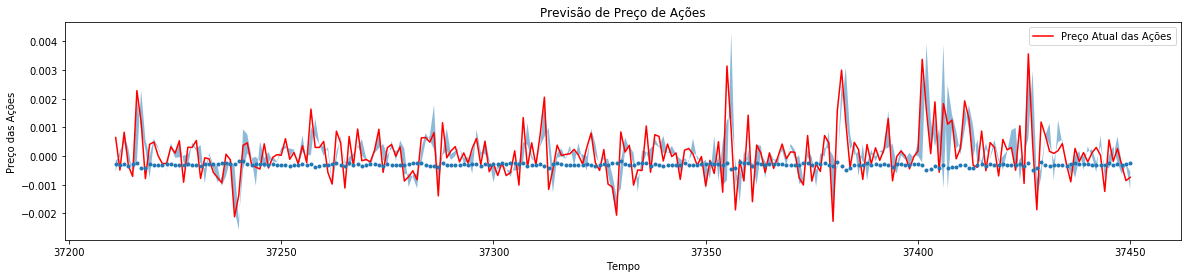

72.78812527656555


In [66]:
begining_training = '2012-01-04'

end_training = '2018-01-01 00:00:00'

end_test = '2019-01-01 00:00:00'

filedataset  = 'GBPUSD.csv'

features = ['open1','high1','low1','close1']

target   = 'close1'

timestamp = 2

neurons = 120

epochs  = 30

datasetProcessed = Processing( filedataset, begining_training, end_training, end_test, timestamp, features, target  )

estatisticalTested  = Testing( modelTrained, datasetProcessed )

estatisticalTested.estatistical()

estatisticalTested.graphicMaxMin(240)